In [16]:
import pandas as pd
import numpy as np
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import time
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib

In [4]:
raw_data_df = pd.read_excel('c:/Users/Harsh/Desktop/trainer/data/Cauvery.xlsx') 
raw_data_df.head()

,Date,Discharge,flood runoff,daily runoff,weekly runoff,Flood
0,1998-01-01,548.0,0.0,0.63,NaN,0.0
1,1998-01-02,548.0,0.0,0.63,NaN,0.0
2,1998-01-03,548.0,0.0,0.63,NaN,0.0
3,1998-01-04,468.0,0.0,0.54,NaN,0.0
4,1998-01-05,652.0,0.0,0.75,NaN,0.0


In [7]:
raw_data_df['Date']=pd.to_datetime(raw_data_df['Date'])
for i in range(1,len(raw_data_df.columns)):
	    raw_data_df[raw_data_df.columns[i]] = raw_data_df[raw_data_df.columns[i]].fillna(raw_data_df[raw_data_df.columns[i]].mean())

data=pd.DataFrame()
data['Date']=raw_data_df["Date"]
data['Discharge']=raw_data_df["Discharge"]
data=data.set_index(['Date'])
	# In[5]:
data.head()


,Discharge
Date,
1998-01-01,548.0
1998-01-02,548.0
1998-01-03,548.0
1998-01-04,468.0
1998-01-05,652.0


<Axes: title={'center': 'Monthly Trends'}, xlabel='Date'>

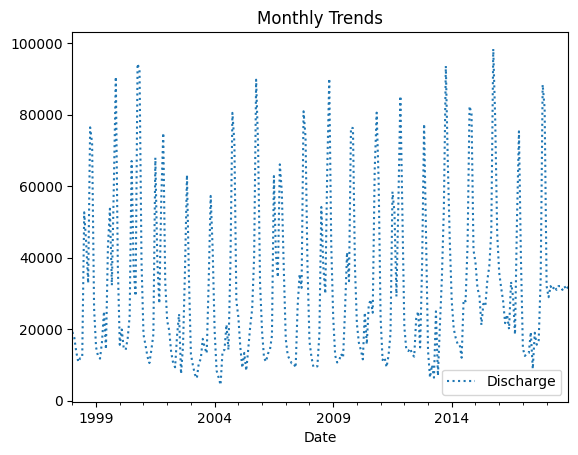

In [8]:
data.isnull().sum()
monthly = data.resample('M').sum()
monthly.plot(style=[':', '--', '-'],title='Monthly Trends')

In [9]:
weekly = data.resample('W').sum()
	#weekly.plot(style=[':', '--', '-'],title='Weekly Trends')

	# In[13]:
daily = data.resample('D').sum()
	#daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'],title='Daily Trends')
daily.head()

,Discharge
Date,
1998-01-01,548.0
1998-01-02,548.0
1998-01-03,548.0
1998-01-04,468.0
1998-01-05,652.0


In [11]:
#Use MinMaxScaler to normalize  to range from 0 to 1
values = daily['Discharge'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# In[27]:
scale=daily
scale["Discharge"]=scaled
scale.head()
# In[28]:
scale.shape

(7670, 1)

In [12]:
def making_dataset(i=1):
	    #Testing the future prediction
	    if i==0 :
	        #Taking data of last two years as testing data
	        df1=scale.iloc[6940:,:]
	        #Training Data
	        df2=scale.iloc[:6940,:]
	        df2.reset_index(inplace=True)
	        # Prophet requires columns ds (Date) and y (value)
	        df2 = df2.rename(columns={'Date': 'ds', 'Discharge': 'y'})
	        return df1,df2
	    else:
	        #Predicting the future values after 2018
	        df2=scale.iloc[:,:]
	        df2.reset_index(inplace=True)
	        # Prophet requires columns ds (Date) and y (value)
	        df2 = df2.rename(columns={'Date': 'ds', 'Discharge': 'y'})
	        return df2,df2

In [14]:
# In[39]:
df1,df2=making_dataset(1)
df2.head()
# In[40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [17]:
df2_prophet = Prophet(changepoint_prior_scale=0.05)
df2_prophet.fit(df2)
path='C:/Users/Harsh/Desktop/trainer/Models'
joblib.dump(df2_prophet, path+'.pkl')
warnings.resetwarnings()

20:17:50 - cmdstanpy - INFO - Chain [1] start processing
20:17:52 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
	def predicting_data(i=1):
	    if i==0:
	        #For testing 
	        # Make a future dataframe for (2 Years)
	        df2_forecast = df2_prophet.make_future_dataframe(periods=30*25 , freq='D')
	        # Make predictions
	        df2_forecast = df2_prophet.predict(df2_forecast)
	        df3=df2_forecast[['ds','yhat']]
	        df3.shape,df1.shape,df2.shape
	        df4=df3.iloc[6940:-20,:]

	    else:
	        #For Future prediction of 2019
	        # Make a future dataframe for 12 months
	        df2_forecast = df2_prophet.make_future_dataframe(periods=30*12 , freq='D',include_history=False)
	        # Make predictions
	        df2_forecast = df2_prophet.predict(df2_forecast)
	        df3=df2_forecast[['ds','yhat']]
	        #df3.shape,df1.shape,df2.shape
	        df4=df3.iloc[:,:]
	    return df4,df2_forecast

In [20]:
	df4,df2_forecast=predicting_data(1)
	ypred=df4.iloc[:,1:]
	ytest=df1.iloc[:,:]
	ypred.shape,ytest.shape

((360, 1), (7670, 2))

In [21]:
	ypred=df4.iloc[:,1:]
	ytest=df1.iloc[:,:]
	ypred.shape,ytest.shape

((360, 1), (7670, 2))